In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

In [ ]:
images_dir = 'E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/datasets/Brain Tumor Segmentation/images'
val_images_dir = 'E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/datasets/Brain Tumor Segmentation/val_images'
test_images_dir = 'E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/datasets/Brain Tumor Segmentation/test_images'

masks_dir = 'E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/datasets/Brain Tumor Segmentation/masks'
val_masks_dir = 'E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/datasets/Brain Tumor Segmentation/valid_masks'
test_masks_dir = 'E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/datasets/Brain Tumor Segmentation/test_masks'

In [17]:
train_coco = COCO(train_annotation_file)
val_coco = COCO(val_annotation_file)
test_coco = COCO(test_annotation_file)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!




### 1. `train_coco = COCO(train_annotation_file)`
- **Explanation**:
  - `COCO` is a class from the `pycocotools.coco` module, which is used to read and manipulate annotation files in the COCO (Common Objects in Context) dataset format.
  - `train_annotation_file` is the path to the annotation file (usually a `.json` file) for the training dataset. It contains metadata about the images, annotations (like bounding boxes or segmentation masks), categories (e.g., object classes), and other related information.
  - This line creates an instance of the `COCO` class for the training dataset, which allows you to load and access information about the annotations.

### 2. `val_coco = COCO(val_annotation_file)`
- **Explanation**:
  - Similar to the previous line, this line creates a `COCO` object for the validation dataset.
  - `val_annotation_file` is the path to the COCO-style annotation file for the validation dataset.
  - This instance (`val_coco`) will allow you to load and access the annotations for the validation set.

### 3. `test_coco = COCO(test_annotation_file)`
- **Explanation**:
  - This line is analogous to the above, but it creates a `COCO` object for the test dataset.
  - `test_annotation_file` is the path to the COCO-style annotation file for the test dataset.
  - The `test_coco` instance will allow you to load and work with the annotations for the test set.

### Key Points
- **COCO annotations** are usually in JSON format, which includes information about:
  - Images: File names, image size, and other metadata.
  - Annotations: Object annotations (bounding boxes, segmentation masks), labels, etc.
  - Categories: Object categories (e.g., "cat", "dog", "car").
- The `pycocotools` library provides a way to interact with COCO-style data efficiently. 
- You can query for specific images or annotations, get category details, and more using the `COCO` class methods.

### Example Usage
Once you have these `COCO` objects (`train_coco`, `val_coco`, `test_coco`), you can use them to access various details. For example:
- Get image details: `train_coco.loadImgs(image_id)`
- Get annotation details: `train_coco.loadAnns(annotation_ids)`
- Get category details: `train_coco.loadCats(category_ids)`


In [18]:
def load_image_and_mask(coco, image_dir, image_id):
    image_info = coco.loadImgs(image_id)[0]
    image_path = os.path.join(image_dir, image_info['file_name'])
    image = Image.open(image_path)
    image = np.array(image)

    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)
    mask = np.zeros((image_info['height'], image_info['width']))
    for ann in anns:
        mask = np.maximum(mask, coco.annToMask(ann))

    return image, mask



### Function Definition
```python
def load_image_and_mask(coco, image_dir, image_id):
```
- **Explanation**:
  - `coco`: The COCO object containing the dataset's annotations (e.g., `train_coco`, `val_coco`, or `test_coco`).
  - `image_dir`: The directory where the images are stored.
  - `image_id`: The unique identifier of the image that you want to load.

This function loads an image and its corresponding mask (which indicates the object regions in the image) based on the annotations in the COCO dataset.

### Step 1: Load Image Info
```python
image_info = coco.loadImgs(image_id)[0]
```
- **Explanation**:
  - `coco.loadImgs(image_id)` loads the metadata (information) of the image identified by `image_id`.
  - This returns a list of image metadata, but since there’s only one image per `image_id`, we access the first (and only) element using `[0]`.
  - `image_info` contains details like the file name, width, height, and other properties of the image.

### Step 2: Construct Image Path
```python
image_path = os.path.join(image_dir, image_info['file_name'])
```
- **Explanation**:
  - This line constructs the full file path to the image by joining the `image_dir` (where images are stored) and the image's file name, which is accessed from `image_info['file_name']`.

### Step 3: Open Image
```python
image = Image.open(image_path)
```
- **Explanation**:
  - `Image.open(image_path)` opens the image file located at `image_path` using the Python Imaging Library (PIL).
  - The image is now loaded into memory as a PIL image object.

### Step 4: Convert Image to NumPy Array
```python
image = np.array(image)
```
- **Explanation**:
  - `np.array(image)` converts the PIL image into a NumPy array, which is the format typically used for image processing in libraries like TensorFlow or OpenCV.
  - This allows you to work with the image as an array of pixel values.

### Step 5: Load Annotations
```python
ann_ids = coco.getAnnIds(imgIds=image_id)
```
- **Explanation**:
  - `coco.getAnnIds(imgIds=image_id)` retrieves the annotation IDs that correspond to the `image_id`.
  - These annotations represent the objects in the image (e.g., bounding boxes, segmentation masks).

### Step 6: Load the Annotations
```python
anns = coco.loadAnns(ann_ids)
```
- **Explanation**:
  - `coco.loadAnns(ann_ids)` loads the annotation data for the given annotation IDs (`ann_ids`).
  - `anns` is a list of annotation objects, which can contain details like object segmentation or bounding box information.

### Step 7: Initialize Mask
```python
mask = np.zeros((image_info['height'], image_info['width']))
```
- **Explanation**:
  - `mask` is initialized as a NumPy array of zeros with the same dimensions as the image (`height` and `width` of the image from `image_info`).
  - The mask will be updated with values that indicate the presence of objects in the image. Initially, all pixels in the mask are set to zero.

### Step 8: Create Mask from Annotations
```python
for ann in anns:
    mask = np.maximum(mask, coco.annToMask(ann))
```
- **Explanation**:
  - For each annotation (`ann`) in the list `anns`, the function `coco.annToMask(ann)` is used to convert the annotation into a binary mask (an array of the same size as the image, where object pixels are 1 and background pixels are 0).
  - `np.maximum(mask, coco.annToMask(ann))` updates the `mask` by taking the element-wise maximum between the current `mask` and the new mask generated from the annotation. This ensures that all objects in the image are included in the final mask.

### Step 9: Return Image and Mask
```python
return image, mask
```
- **Explanation**:
  - Finally, the function returns both the loaded image (as a NumPy array) and the corresponding mask (also a NumPy array).
  - The mask represents the segmentation of the objects in the image, with object regions marked as 1 and the background as 0.

### Summary
- The function loads an image and its corresponding mask based on COCO-style annotations.
- It retrieves metadata about the image, loads the image itself, and then creates a binary mask from the annotations that indicate the regions where objects are located.
- The output is the image and its mask, both in NumPy array format.

In [19]:
def create_tf_dataset(coco, image_dir, image_ids):
    def generator():
        for image_id in image_ids:
            yield load_image_and_mask(coco, image_dir, image_id)

    return tf.data.Dataset.from_generator(generator,
                                          output_signature=(tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8), 
                                                            tf.TensorSpec(shape=(None, None), dtype=tf.uint8)))

train_dataset = create_tf_dataset(train_coco, train_dir, train_coco.getImgIds())
val_dataset = create_tf_dataset(val_coco, val_dir, val_coco.getImgIds())
test_dataset = create_tf_dataset(test_coco, test_dir, test_coco.getImgIds())


#### 1. Function Definition: `create_tf_dataset`
```python
def create_tf_dataset(coco, image_dir, image_ids):
```
- **Explanation**: This function defines a custom TensorFlow dataset. It takes three parameters:
  - `coco`: The COCO object containing the annotations for a dataset (could be training, validation, or testing COCO object).
  - `image_dir`: The directory where the image files are stored.
  - `image_ids`: A list of image IDs that you want to include in the dataset (obtained from `coco.getImgIds()`).

#### 2. Generator Function Definition: `generator()`
```python
def generator():
    for image_id in image_ids:
        yield load_image_and_mask(coco, image_dir, image_id)
```
- **Explanation**: 
  - This is a Python generator function that iterates over the `image_ids` and for each `image_id`, it calls the `load_image_and_mask` function (which loads an image and its corresponding mask) and yields the image and mask as a tuple.
  - The `yield` keyword produces a sequence of data points lazily, which means it doesn’t load all the data into memory at once, making it memory efficient.

#### 3. TensorFlow Dataset Creation
```python
return tf.data.Dataset.from_generator(generator,
                                      output_signature=(tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
                                                        tf.TensorSpec(shape=(None, None), dtype=tf.uint8)))
```
- **Explanation**:
  - `tf.data.Dataset.from_generator(generator)` creates a TensorFlow dataset using the generator function.
  - `output_signature` specifies the data types and shapes for the elements in the dataset. 
    - The first element is the image, which is a 3-dimensional array (`height`, `width`, 3 channels for RGB) of type `tf.uint8`.
    - The second element is the mask, which is a 2-dimensional array (`height`, `width`) of type `tf.uint8`.
  - This setup ensures that TensorFlow understands the shape and data type of the data it will receive from the generator function.

#### 4. Create Datasets for Training, Validation, and Testing
```python
train_dataset = create_tf_dataset(train_coco, train_dir, train_coco.getImgIds())
val_dataset = create_tf_dataset(val_coco, val_dir, val_coco.getImgIds())
test_dataset = create_tf_dataset(test_coco, test_dir, test_coco.getImgIds())
```
- **Explanation**:
  - These lines create three separate datasets: `train_dataset`, `val_dataset`, and `test_dataset` by calling the `create_tf_dataset` function.
  - For each dataset:
    - `train_coco`, `val_coco`, and `test_coco` are the COCO objects for the training, validation, and test sets, respectively.
    - `train_dir`, `val_dir`, and `test_dir` are the directories containing the respective images.
    - `train_coco.getImgIds()`, `val_coco.getImgIds()`, and `test_coco.getImgIds()` return the image IDs for each set, which are passed into the `create_tf_dataset` function.

### Summary:
- **`create_tf_dataset`**:
  - This function takes the COCO object, image directory, and image IDs to create a TensorFlow dataset using a generator function.
  - The generator yields image-mask pairs lazily, and the dataset is built from this generator.
  
- **Creating Datasets**:
  - The three datasets (`train_dataset`, `val_dataset`, and `test_dataset`) are created for training, validation, and testing by passing the appropriate arguments (COCO objects, directories, and image IDs).
  
- **Dataset Elements**:
  - Each element in the dataset consists of an image and its corresponding mask, both represented as TensorFlow tensors. The image is a 3D tensor, and the mask is a 2D tensor.

This approach is efficient because it lazily loads images and masks only when needed during model training or evaluation.

In [21]:
def preprocess(image, mask):
    
    image = tf.image.resize(image, (256, 256))
    
    mask = tf.expand_dims(mask, axis=-1)  
    mask = tf.image.resize(mask, (256, 256))
 
    image = tf.cast(image, tf.float32) / 255.0
    
    return image, mask

train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

#### 1. Function Definition: `preprocess`
```python
def preprocess(image, mask):
```
- **Explanation**: This function defines the preprocessing steps that will be applied to each image-mask pair in the dataset. It takes two inputs:
  - `image`: The image tensor that needs to be preprocessed.
  - `mask`: The mask tensor that corresponds to the image, typically used for segmentation tasks.

#### 2. Resize the Image
```python
image = tf.image.resize(image, (256, 256))
```
- **Explanation**: 
  - This line resizes the image to the target dimensions of `(256, 256)`. This is a common preprocessing step to standardize the input size for the neural network.
  - `tf.image.resize` is a TensorFlow function used for resizing images.
  - The resized image will have the shape `(256, 256, 3)` where 3 is the number of color channels (RGB).

#### 3. Expand the Mask Dimensions
```python
mask = tf.expand_dims(mask, axis=-1)
```
- **Explanation**: 
  - This line adds a new dimension to the mask at the last axis (`axis=-1`), transforming the mask from a shape of `(height, width)` into `(height, width, 1)`. This is because masks often have a single channel (grayscale), and for compatibility with the neural network, it's useful to treat the mask as a 3D tensor with the last dimension representing the channels.
  - In some cases, this step ensures that the mask's shape aligns with that of the image (both become `(256, 256, 1)`).

#### 4. Resize the Mask
```python
mask = tf.image.resize(mask, (256, 256))
```
- **Explanation**: 
  - This line resizes the mask to the target dimensions of `(256, 256)` to match the resized image size.
  - Just like for the image, this ensures that the mask has the same spatial dimensions as the image, which is crucial for segmentation tasks where the mask is compared to the image during training.

#### 5. Normalize the Image
```python
image = tf.cast(image, tf.float32) / 255.0
```
- **Explanation**: 
  - This line normalizes the pixel values of the image. TensorFlow images are typically in the `uint8` format (with pixel values ranging from 0 to 255). By casting the image to `float32` and dividing by 255, the pixel values are scaled to the range `[0, 1]`, which is a common practice when working with neural networks.
  - Normalizing pixel values helps the model learn more efficiently by avoiding large values that might slow down the optimization process.

#### 6. Return Processed Image and Mask
```python
return image, mask
```
- **Explanation**: The function returns the preprocessed image and mask. After this preprocessing, the image is resized, normalized, and the mask is resized and reshaped, making them ready for input to the neural network.

---

#### 7. Applying Preprocessing to the Dataset
```python
train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)
```
- **Explanation**:
  - These lines apply the `preprocess` function to each element (image-mask pair) in the datasets (`train_dataset`, `val_dataset`, `test_dataset`).
  - `.map(preprocess)` is a method in TensorFlow's `tf.data.Dataset` API that applies the `preprocess` function to each element of the dataset. This operation does not modify the original datasets but returns a new dataset with the preprocessed data.
  
  - After calling `.map(preprocess)`, each dataset element will be a preprocessed image and mask, with the image normalized and resized to `(256, 256, 3)` and the mask resized to `(256, 256, 1)`.

---

### Summary:
- The `preprocess` function:
  1. Resizes the image and mask to `(256, 256)`.
  2. Normalizes the image by scaling its pixel values between 0 and 1.
  3. Adds an extra channel to the mask to make it a 3D tensor with shape `(height, width, 1)`.
  
- The `.map(preprocess)` method is used to apply this preprocessing to all elements in the training, validation, and testing datasets.

This ensures that the image and mask data are consistently formatted for input into the neural network, aiding in model training and evaluation.

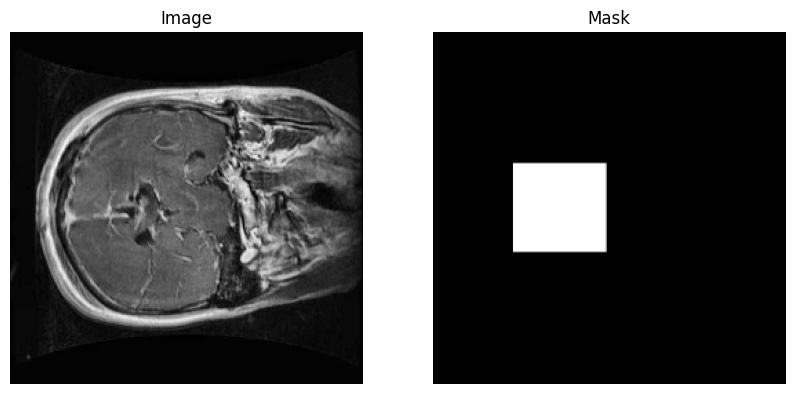

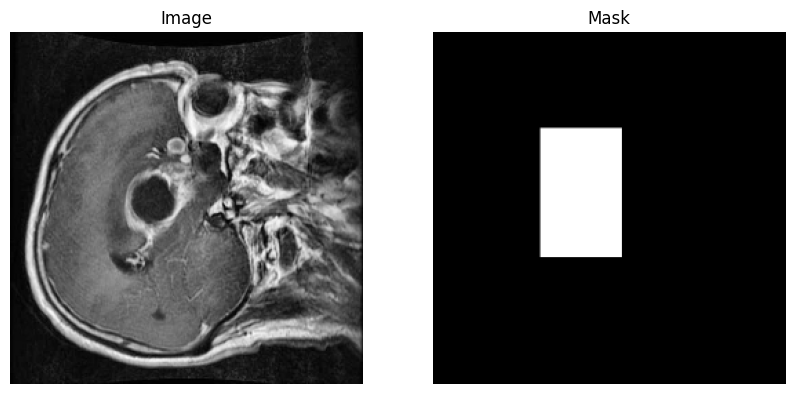

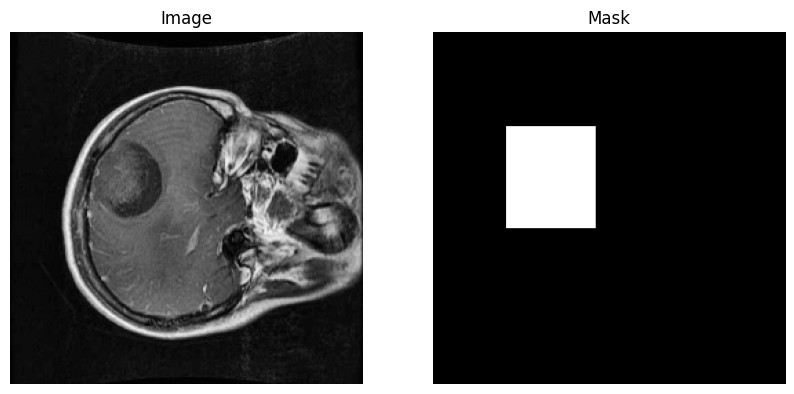

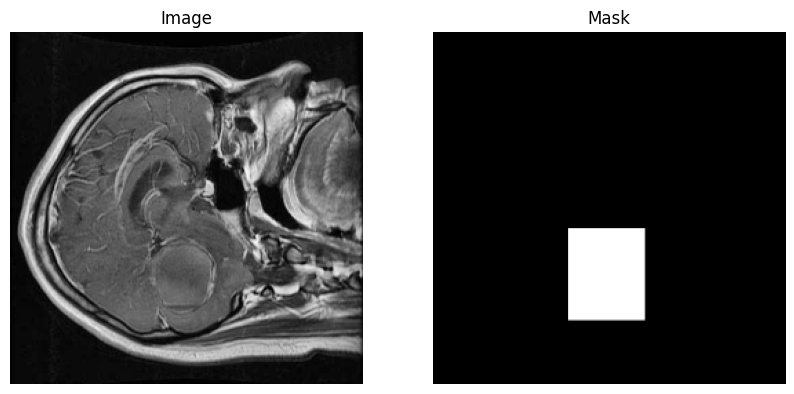

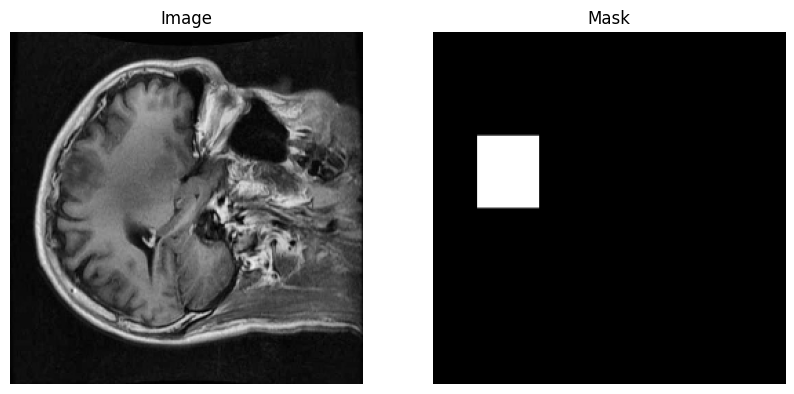

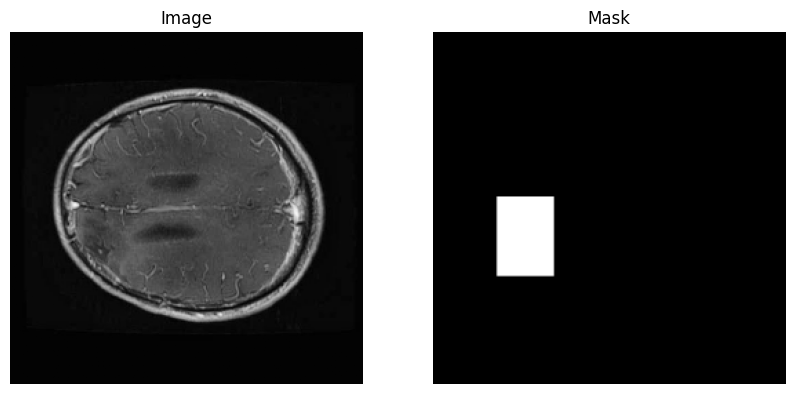

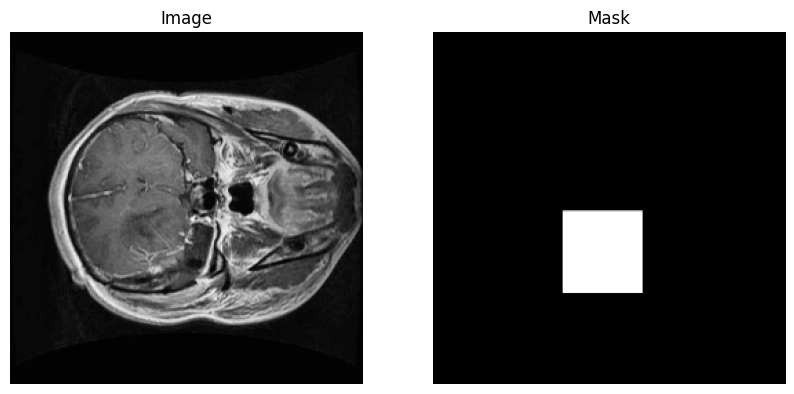

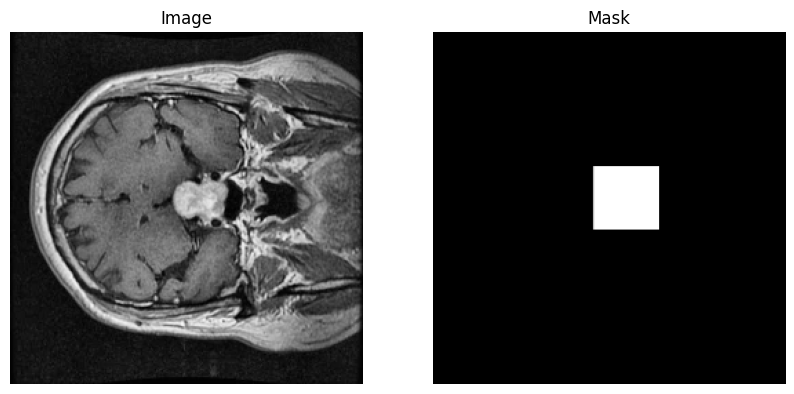

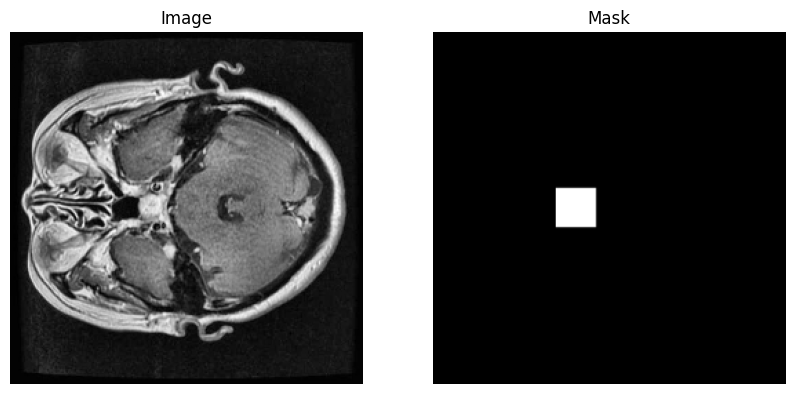

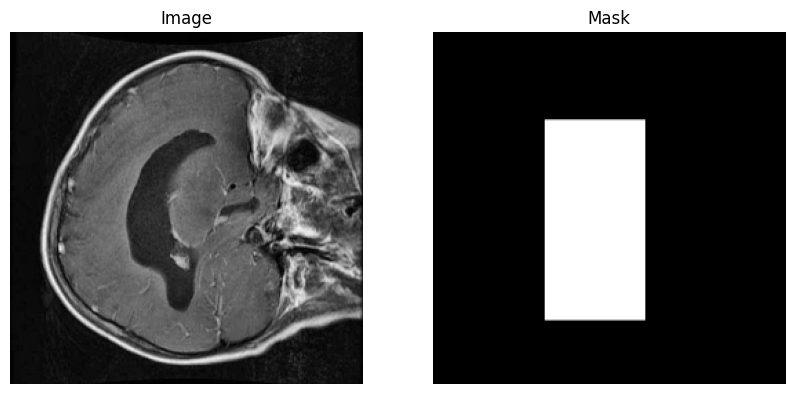

In [22]:
def visualize_dataset(dataset, num_samples=5):
    for i, (image, mask) in enumerate(dataset.take(num_samples)):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(image.numpy())
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(mask.numpy().squeeze(), cmap="gray")
        plt.title("Mask")
        plt.axis("off")

        plt.show()

visualize_dataset(train_dataset)
visualize_dataset(val_dataset)

In [24]:
def downsampling_block(x, n_filters):
    c = layers.Conv2D(n_filters, (3, 3), activation='relu', padding='same')(x)
    c = layers.Conv2D(n_filters, (3, 3), activation='relu', padding='same')(c)
    p = layers.MaxPooling2D((2, 2))(c)
    return c, p

def upsampling_block(x, skip_connection, n_filters):
    u = layers.Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(x)
    u = layers.concatenate([u, skip_connection])
    c = layers.Conv2D(n_filters, (3, 3), activation='relu', padding='same')(u)
    c = layers.Conv2D(n_filters, (3, 3), activation='relu', padding='same')(c)
    return c

def unet_model(input_size=(256, 256, 3), n_filters=32, n_classes=1):
    inputs = layers.Input(input_size)

    dblock1, p1 = downsampling_block(inputs, n_filters)
    dblock2, p2 = downsampling_block(p1, n_filters * 2)
    dblock3, p3 = downsampling_block(p2, n_filters * 4)
    dblock4, p4 = downsampling_block(p3, n_filters * 8)

    bottleneck = layers.Conv2D(n_filters * 16, (3, 3), activation='relu', padding='same')(p4)
    bottleneck = layers.Conv2D(n_filters * 16, (3, 3), activation='relu', padding='same')(bottleneck)

    u6 = upsampling_block(bottleneck, dblock4, n_filters * 8)
    u7 = upsampling_block(u6, dblock3, n_filters * 4)
    u8 = upsampling_block(u7, dblock2, n_filters * 2)
    u9 = upsampling_block(u8, dblock1, n_filters)

    outputs = layers.Conv2D(n_classes, (1, 1), activation='sigmoid' if n_classes == 1 else 'softmax')(u9)

    model = models.Model(inputs, outputs)

    return model

model = unet_model(input_size=(256, 256, 3), n_filters=32)



### 1. Downsampling Block (Contracting Path)
```python
def downsampling_block(x, n_filters):
    c = layers.Conv2D(n_filters, (3, 3), activation='relu', padding='same')(x)
    c = layers.Conv2D(n_filters, (3, 3), activation='relu', padding='same')(c)
    p = layers.MaxPooling2D((2, 2))(c)
    return c, p
```
- **Input**: The function accepts two arguments:
  - `x`: The input tensor (either the initial image or the output from the previous layer).
  - `n_filters`: The number of filters for the convolution layers.
  
- **Operations**:
  - Two convolutional layers (`Conv2D`) are applied with ReLU activation, each with 3x3 kernels, to capture the features of the image. The padding is set to `'same'`, meaning the output has the same spatial dimensions as the input.
  - A `MaxPooling2D` layer with a 2x2 pool size is used to downsample the feature map, reducing its spatial dimensions by a factor of 2.

- **Output**:
  - `c`: The output of the second convolutional layer (feature maps).
  - `p`: The output of the max pooling layer (downsampled feature map).

---

### 2. Upsampling Block (Expanding Path)
```python
def upsampling_block(x, skip_connection, n_filters):
    u = layers.Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(x)
    u = layers.concatenate([u, skip_connection])
    c = layers.Conv2D(n_filters, (3, 3), activation='relu', padding='same')(u)
    c = layers.Conv2D(n_filters, (3, 3), activation='relu', padding='same')(c)
    return c
```
- **Input**: This function receives three arguments:
  - `x`: The input tensor (output of the bottleneck or previous upsampling layer).
  - `skip_connection`: The corresponding feature map from the contracting path (downsampling path) to help the upsampling layer maintain detailed information.
  - `n_filters`: The number of filters for the convolution layers.
  
- **Operations**:
  - `Conv2DTranspose` is used for upsampling. It performs a deconvolution operation to increase the spatial dimensions of the input tensor.
  - The `skip_connection` (output from the downsampling block) is concatenated with the upsampled tensor. This helps the network retain spatial information from the contracting path, which is crucial for accurate segmentation.
  - Two convolutional layers (`Conv2D`) with ReLU activation and 3x3 kernels are applied to refine the upsampled tensor.

- **Output**: The function returns the refined tensor (`c`) after upsampling and convolution.

---

### 3. U-Net Model Architecture
```python
def unet_model(input_size=(256, 256, 3), n_filters=32, n_classes=1):
    inputs = layers.Input(input_size)

    # Contracting path (downsampling)
    dblock1, p1 = downsampling_block(inputs, n_filters)
    dblock2, p2 = downsampling_block(p1, n_filters * 2)
    dblock3, p3 = downsampling_block(p2, n_filters * 4)
    dblock4, p4 = downsampling_block(p3, n_filters * 8)

    # Bottleneck
    bottleneck = layers.Conv2D(n_filters * 16, (3, 3), activation='relu', padding='same')(p4)
    bottleneck = layers.Conv2D(n_filters * 16, (3, 3), activation='relu', padding='same')(bottleneck)

    # Expanding path (upsampling)
    u6 = upsampling_block(bottleneck, dblock4, n_filters * 8)
    u7 = upsampling_block(u6, dblock3, n_filters * 4)
    u8 = upsampling_block(u7, dblock2, n_filters * 2)
    u9 = upsampling_block(u8, dblock1, n_filters)

    # Output layer
    outputs = layers.Conv2D(n_classes, (1, 1), activation='sigmoid' if n_classes == 1 else 'softmax')(u9)

    # Create model
    model = models.Model(inputs, outputs)

    return model
```
- **Input Parameters**:
  - `input_size=(256, 256, 3)`: Specifies the input size of the images (256x256 pixels with 3 color channels).
  - `n_filters=32`: The number of filters in the initial convolutional layers.
  - `n_classes=1`: The number of output classes. For binary segmentation, `n_classes=1` with a sigmoid activation. For multi-class segmentation, `n_classes > 1` with a softmax activation.

- **Architecture**:
  - **Contracting Path**: The model uses 4 downsampling blocks. Each block contains two convolutional layers followed by max pooling, and the number of filters increases as we go deeper into the network:
    - `dblock1, p1`: First downsampling block.
    - `dblock2, p2`: Second downsampling block.
    - `dblock3, p3`: Third downsampling block.
    - `dblock4, p4`: Fourth downsampling block.
  
  - **Bottleneck**: After the last downsampling block (`p4`), the bottleneck layer is created using two convolutional layers with a higher number of filters (`n_filters * 16`).
  
  - **Expanding Path**: The model then upsamples through 4 upsampling blocks, where each block uses a `Conv2DTranspose` layer (for upsampling) followed by convolution layers, and concatenates skip connections from the contracting path:
    - `u6`: Upsampling using `dblock4` (first upsampling).
    - `u7`: Upsampling using `dblock3` (second upsampling).
    - `u8`: Upsampling using `dblock2` (third upsampling).
    - `u9`: Upsampling using `dblock1` (fourth upsampling).
  
  - **Output Layer**: The output layer consists of a `Conv2D` with a kernel size of `1x1` to map the features to the final number of classes. For binary segmentation (`n_classes=1`), the activation function is `sigmoid`. For multi-class segmentation (`n_classes > 1`), the activation function is `softmax`.

- **Model Creation**: The model is created by passing the input and output layers to the `Model` class from Keras.

---

### 4. Create the Model
```python
model = unet_model(input_size=(256, 256, 3), n_filters=32)
```
- **Explanation**: This line calls the `unet_model` function to create a U-Net model with the specified input size `(256, 256, 3)` and `n_filters=32`. The model will have one output class (default for binary segmentation).

---

### Summary:
- This code defines a U-Net model used for image segmentation. It has a contracting path (downsampling) followed by an expanding path (upsampling), where skip connections are used to retain fine-grained spatial information from the contracting path during the upsampling process. The final output layer depends on the number of classes and applies a `sigmoid` or `softmax` activation accordingly. The model is designed to be flexible, allowing the number of filters and output classes to be easily adjusted.

In [25]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def combined_loss(y_true, y_pred):
    dice = dice_loss(y_true, y_pred)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return 0.6 * dice + 0.4 * bce

metrics = ["accuracy", dice_coef]

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss=combined_loss, metrics=metrics)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 32)   │            896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 32)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 64)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 256)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 256)    │        524,544 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concaten

 Total params: 7,760,097 (29.60 MB)

 Trainable params: 7,760,097 (29.60 MB)

 Non-trainable params: 0 (0.00 B)


### 1. **Dice Coefficient**
```python
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
```

- **Purpose**: The Dice Coefficient is a metric used to evaluate the similarity between two samples. It ranges from 0 (no overlap) to 1 (perfect overlap). In segmentation tasks, it's a critical metric for measuring the quality of the predicted segmentation mask compared to the ground truth.
  
- **Explanation**:
  - **Flattening**: `y_true` and `y_pred` are flattened into 1D arrays using `K.flatten()`, so they can be compared element-wise.
  - **Intersection**: The element-wise product of the true and predicted values (`y_true_f * y_pred_f`) is summed to find the intersection.
  - The `smooth` term is added to avoid division by zero in cases where both `y_true` and `y_pred` are zero.

---

### 2. **Dice Loss**
```python
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)
```

- **Purpose**: Dice Loss is used to minimize the Dice Coefficient by maximizing the overlap between the predicted and true masks. This is commonly used in image segmentation tasks.
  
  - By minimizing this loss, the network tries to maximize the similarity between the predicted segmentation mask and the true mask.

---

### 3. **Combined Loss Function**
```python
def combined_loss(y_true, y_pred):
    dice = dice_loss(y_true, y_pred)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return 0.6 * dice + 0.4 * bce
```

- **Purpose**: This function combines the **Dice Loss** and **Binary Cross-Entropy (BCE)** loss to create a more balanced loss function that incorporates both segmentation quality (Dice) and pixel-wise classification (BCE).

- **Explanation**:
  - `dice_loss(y_true, y_pred)` computes the Dice Loss.
  - `tf.keras.losses.binary_crossentropy(y_true, y_pred)` computes the Binary Cross-Entropy Loss. This loss is used to measure the accuracy of pixel-wise classification.
  - This allows the model to optimize both the segmentation quality and the pixel classification accuracy. The weights (0.6 and 0.4) are used to control the influence of each loss term.

---

### 4. **Model Compilation**
```python
metrics = ["accuracy", dice_coef]

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss=combined_loss, metrics=metrics)
model.summary()
```

- **Purpose**: This block compiles the U-Net model with the custom loss functions and metrics, and prints the model summary.

- **Explanation**:
  - `metrics = ["accuracy", dice_coef]`: This specifies that the model should track **accuracy** and the **Dice Coefficient** during training and evaluation.
  - `optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)`: This defines the Adam optimizer with a learning rate of \(1 \times 10^{-4}\). Adam is a popular optimizer due to its adaptive learning rates and efficiency.
  - `model.compile(...)`: The model is compiled using:
    - `optimizer`: The Adam optimizer.
    - `loss`: The combined loss function, which includes both Dice Loss and Binary Cross-Entropy Loss.
    - `metrics`: The metrics to track during training (accuracy and Dice Coefficient).
  - `model.summary()`: This prints the summary of the model, including the architecture, the number of parameters, and the output shapes.

---

### Summary:
- The code defines custom loss functions (`Dice Loss`, `Combined Loss`) and metric (`Dice Coefficient`) for a segmentation task using U-Net.
- The **combined loss** balances the **Dice Loss** and **Binary Cross-Entropy (BCE)** to optimize both segmentation accuracy and pixel classification.
- The model is compiled with the **Adam optimizer**, **combined loss**, and **Dice Coefficient** metric. This prepares the model for training on the dataset.

In [26]:
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

steps_per_epoch = len(train_coco.getImgIds()) // BATCH_SIZE
validation_steps = len(val_coco.getImgIds()) // BATCH_SIZE
test_steps = len(test_coco.getImgIds()) // BATCH_SIZE



### 1. **Setting up batch size and data prefetching**

```python
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE
```

- **BATCH_SIZE**: This is the number of samples that will be processed together in one forward/backward pass through the network. In this case, 16 samples will be processed in each batch.
- **AUTOTUNE**: This is used to allow TensorFlow to automatically tune the prefetch buffer size. It helps in optimizing the performance by preloading data while training the model, minimizing idle time.

### 2. **Preparing the training, validation, and test datasets**

```python
train_dataset = train_dataset.repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
```

- **train_dataset.repeat()**: Repeats the dataset indefinitely. This ensures that the dataset will continue looping through the samples without stopping, which is important for training since we need to loop through all the data multiple times (epochs).
  
- **batch(BATCH_SIZE)**: This batches the dataset by the specified **BATCH_SIZE**. Each batch will have **16** images and their corresponding labels.

- **prefetch(buffer_size=AUTOTUNE)**: Prefetches the data to ensure that the data loading happens in the background while the model is training on the current batch. By using **AUTOTUNE**, TensorFlow automatically determines the optimal number of batches to prefetch.

For the **test_dataset**, we don’t repeat it because typically test data is only processed once, so only **batching** and **prefetching** is done.

### 3. **Calculating steps per epoch, validation steps, and test steps**

```python
steps_per_epoch = len(train_coco.getImgIds()) // BATCH_SIZE
validation_steps = len(val_coco.getImgIds()) // BATCH_SIZE
test_steps = len(test_coco.getImgIds()) // BATCH_SIZE
```

- **steps_per_epoch**: The number of steps the model needs to take in one epoch while training. This is calculated by dividing the total number of training samples by the **BATCH_SIZE**. It defines how many batches of data the model will process in each epoch. `train_coco.getImgIds()` returns the total number of images in the training set.
  
- **validation_steps**: Similar to steps per epoch, but for the validation dataset. It calculates how many batches need to be processed for the validation data.

- **test_steps**: Number of batches for the test set. Test data is used for final evaluation, so it's processed once.

### Summary of Data Pipeline Setup:
- **Repeat**: Ensures the dataset is continuously looped during training.
- **Batch**: Splits the dataset into batches of 16 samples.
- **Prefetch**: Optimizes data loading by prefetching data while the model is training on the current batch.
- **Steps per epoch**: Calculated based on the size of the dataset divided by the batch size.

This setup is critical for improving the efficiency of training by reducing idle time and ensuring smooth data processing throughout the training process.

In [27]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=1e-5)
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 85s 497ms/step - accuracy: 0.9571 - dice_coef: 0.0515 - loss: 0.7699 - val_accuracy: 0.9627 - val_dice_coef: 0.1525 - val_loss: 0.5743 - learning_rate: 1.0000e-04
Epoch 2/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 32s 350ms/step - accuracy: 0.9615 - dice_coef: 0.1614 - loss: 0.5674 - val_accuracy: 0.9622 - val_dice_coef: 0.1998 - val_loss: 0.5478 - learning_rate: 1.0000e-04
Epoch 3/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 34s 371ms/step - accuracy: 0.9612 - dice_coef: 0.2023 - loss: 0.5397 - val_accuracy: 0.9627 - val_dice_coef: 0.2182 - val_loss: 0.5233 - learning_rate: 1.0000e-04
Epoch 4/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 35s 374ms/step - accuracy: 0.9489 - dice_coef: 0.2315 - loss: 0.5219 - val_accuracy: 0.9607 - val_dice_coef: 0.2778 - val_loss: 0.4895 - learning_rate: 1.0000e-04
Epoch 5/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 34s 370ms/step - accuracy: 0.9482 - dice_coef: 0.3202 - loss: 0.4703 - val_accuracy: 0.9612 - val_dice_coef: 0.3331 - val_loss: 0.4564 - learning_rate: 1.0000e-04



### 1. **Learning Rate Scheduler: `ReduceLROnPlateau`**

```python
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=1e-5)
```

- **monitor='val_loss'**: This tells the callback to monitor the validation loss (`val_loss`) during training. The learning rate will be adjusted based on this metric.
  
- **factor=0.1**: This indicates that when the validation loss plateaus (does not improve for a specified number of epochs), the learning rate will be reduced by a factor of 0.1. For example, if the current learning rate is 0.001, it will be reduced to 0.0001.

- **patience=4**: The number of epochs to wait after the last improvement before reducing the learning rate. In this case, if there is no improvement in `val_loss` for 4 consecutive epochs, the learning rate will be reduced.

- **min_lr=1e-5**: The minimum possible learning rate. The learning rate will never be reduced below this value, even after applying the factor.

### 2. **Early Stopping: `EarlyStopping`**

```python
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
```

- **monitor='val_loss'**: Similar to `ReduceLROnPlateau`, this monitors the validation loss during training. 

- **patience=8**: This specifies the number of epochs to wait before stopping the training if there is no improvement in validation loss. If the validation loss does not improve for 8 consecutive epochs, training will stop early.

- **restore_best_weights=True**: When early stopping is triggered, this ensures that the model's weights are restored to the best weights observed during training, not the weights from the final epoch (which may be overfitted).

### 3. **Training the Model**

```python
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr]
)
```

- **train_dataset**: The training data that was preprocessed and batched.
  
- **validation_data=val_dataset**: The validation data to evaluate the model's performance after each epoch.

- **epochs=5**: The total number of epochs to train the model. In this case, the model will train for 5 epochs, but the training may stop earlier if early stopping is triggered.

- **steps_per_epoch=steps_per_epoch**: This specifies the number of steps (batches) to be processed in each epoch. It is determined by dividing the total number of training samples by the batch size.

- **validation_steps=validation_steps**: Similar to steps per epoch, but for the validation dataset. This is the number of validation batches to process in each epoch.

- **callbacks=[early_stopping, reduce_lr]**: The callbacks that will be used during training. 
    - `early_stopping`: Stops training early if the validation loss does not improve for 8 epochs.
    - `reduce_lr`: Reduces the learning rate by a factor of 0.1 if the validation loss does not improve for 4 epochs.

### Summary of the Training Process:
- **ReduceLROnPlateau** adjusts the learning rate when the validation loss stops improving.
- **EarlyStopping** prevents overfitting by stopping training early if validation loss doesn't improve after a certain number of epochs.
- **Model training** proceeds for up to 5 epochs, but it could stop earlier due to the callbacks.

This setup helps to optimize the model’s performance by avoiding overfitting (with early stopping) and ensuring that the learning rate is adjusted based on the validation performance (with `ReduceLROnPlateau`).

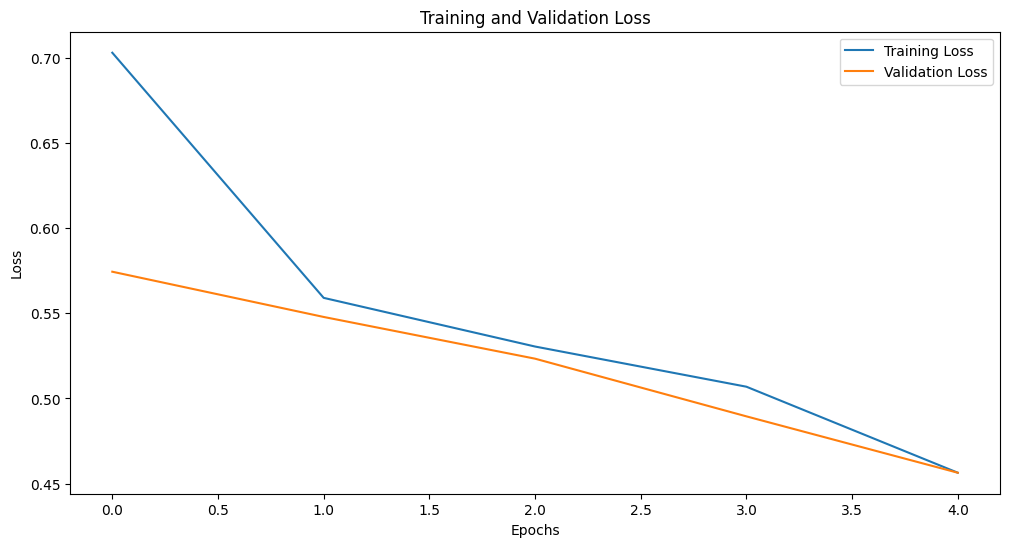

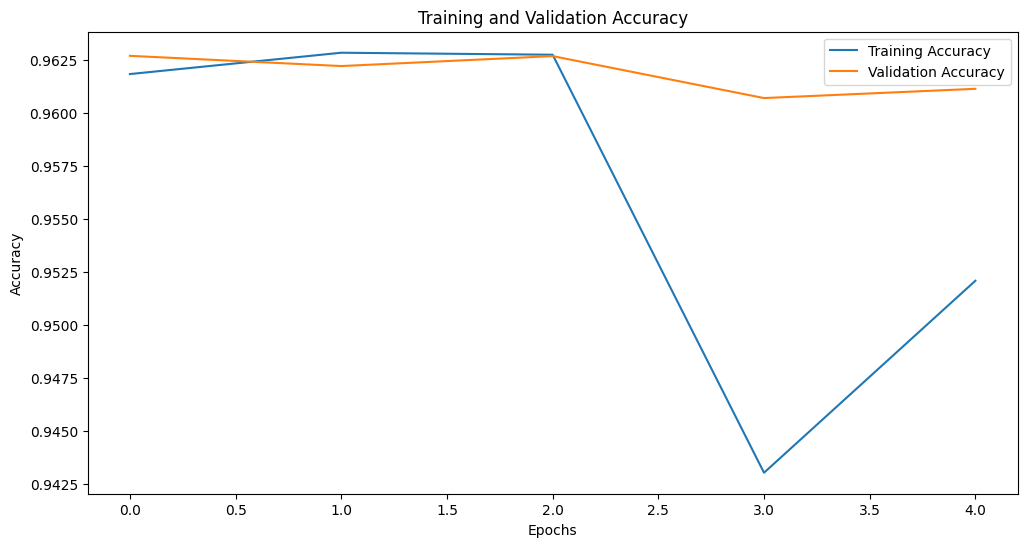

In [28]:
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_loss(history)
plot_accuracy(history)

In [29]:
test_loss, test_accuracy, test_coef = model.evaluate(test_dataset, steps=test_steps)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test Dice Coefficient: {test_coef}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - accuracy: 0.9564 - dice_coef: 0.3160 - loss: 0.4735
Test Loss: 0.4651889204978943, Test Accuracy: 0.9592363834381104, Test Dice Coefficient: 0.32101914286613464


In [30]:
def visualize_predictions(model, dataset, num_samples=5, threshold=0.5):

    random_batch = random.choice(list(dataset))
    images, masks = random_batch

    indices = random.sample(range(len(images)), min(num_samples, len(images)))

    predictions = model.predict(images)

    binary_predictions = (predictions > threshold).astype('uint8')

    for i in indices:
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i].numpy().squeeze(), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(binary_predictions[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()

In [33]:
import random

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


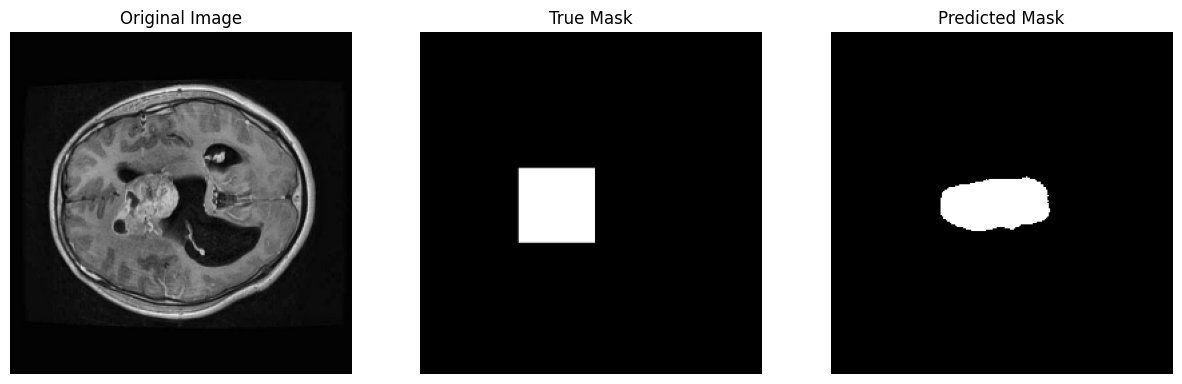

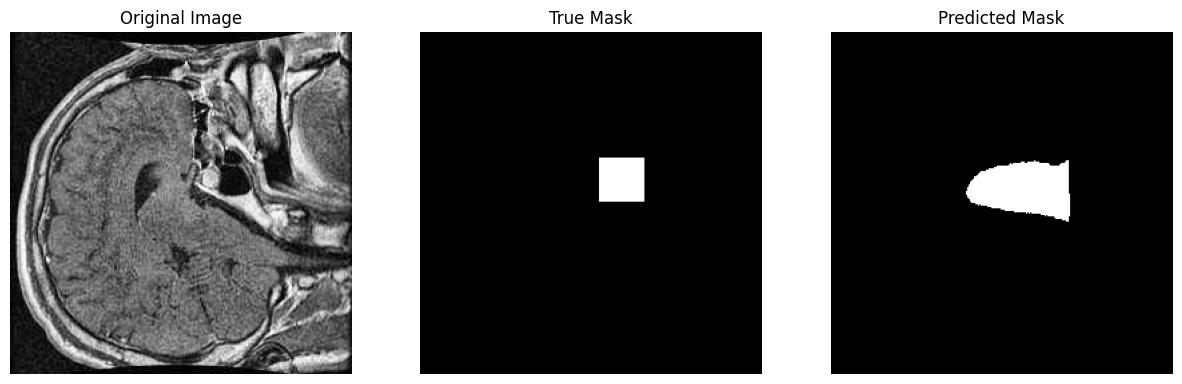

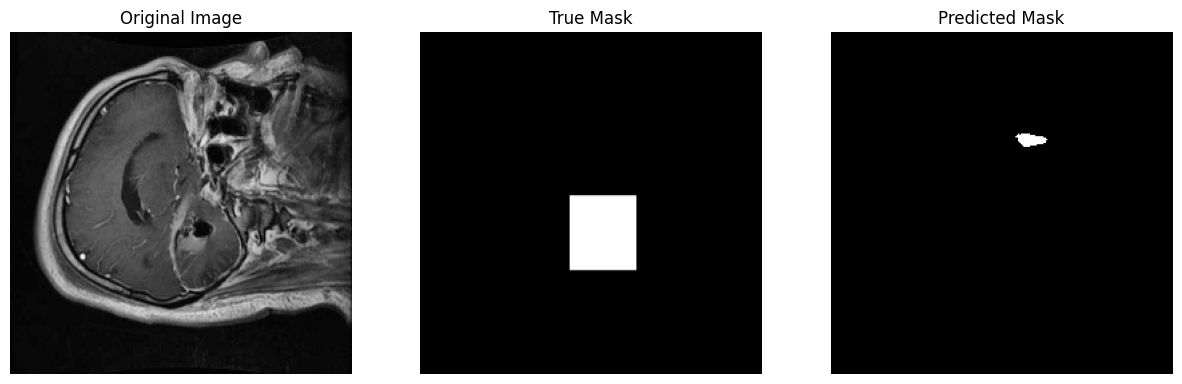

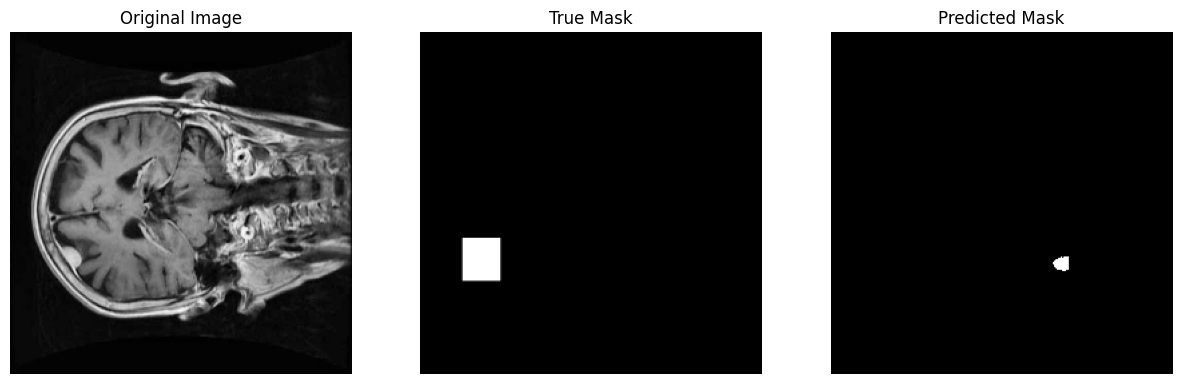

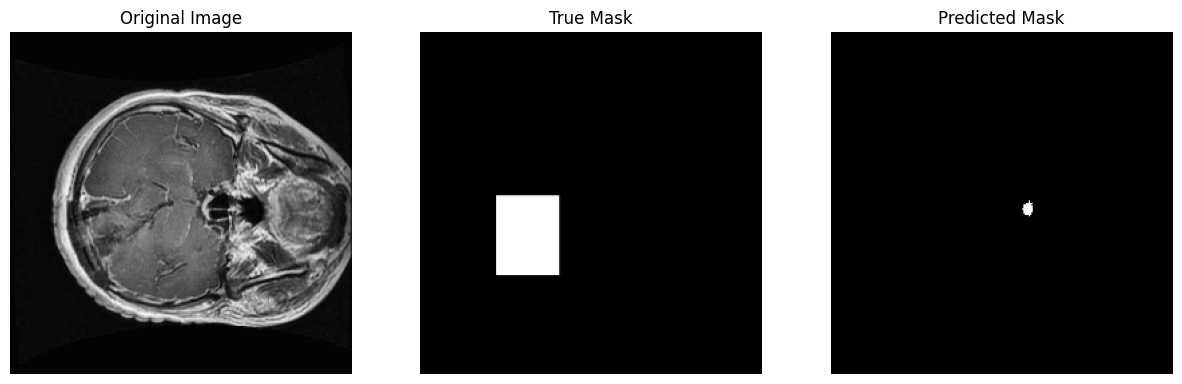

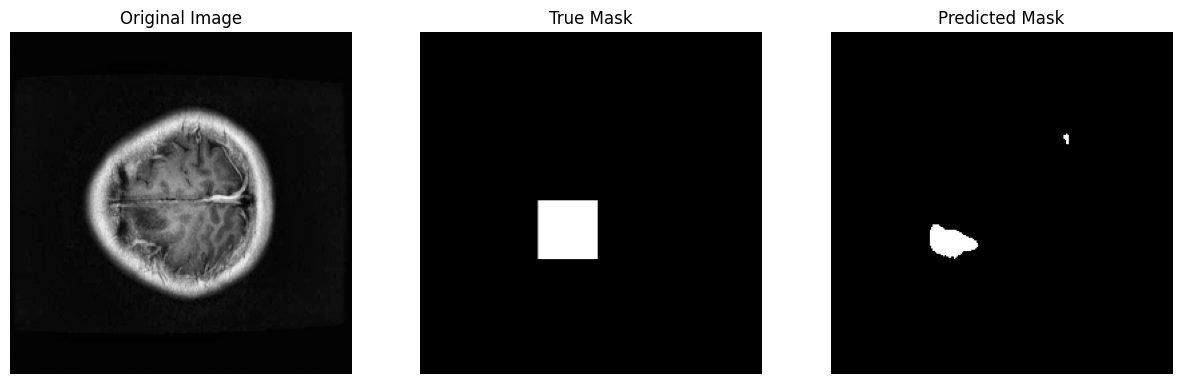

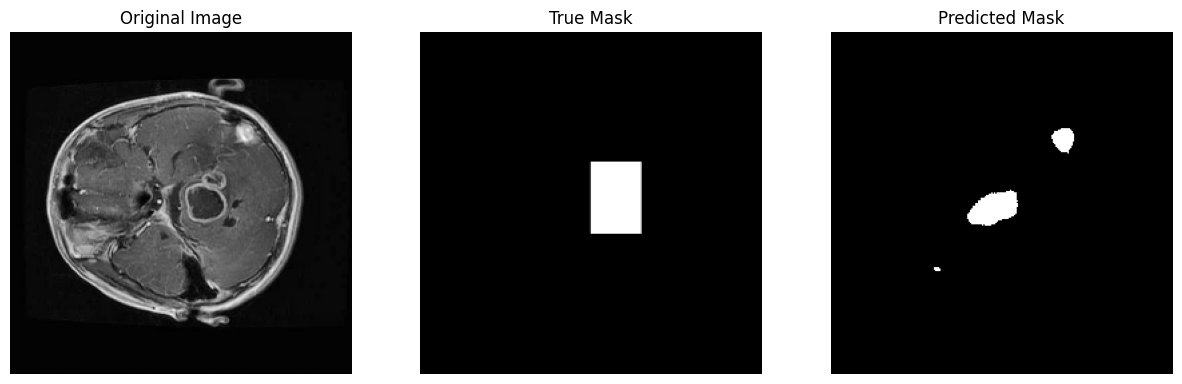

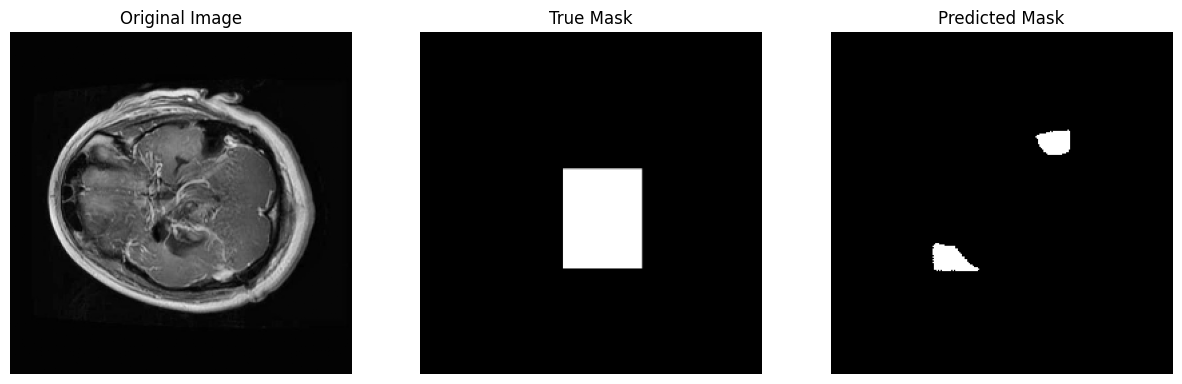

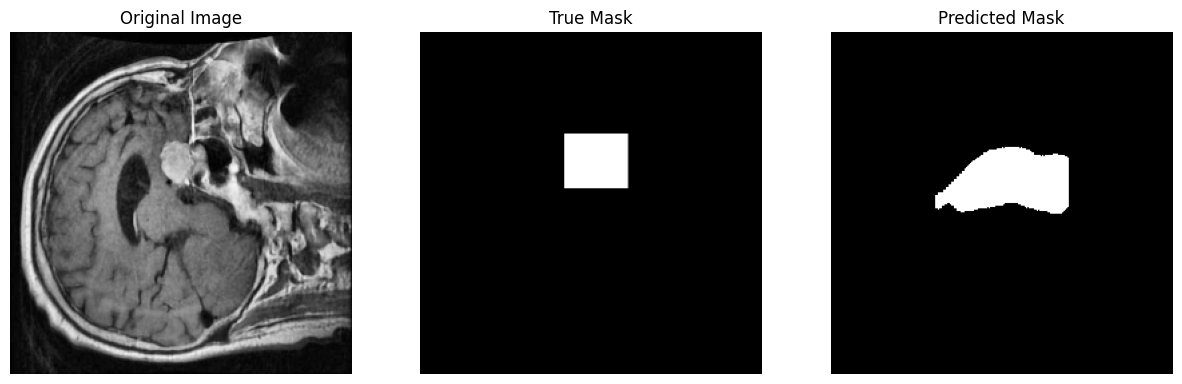

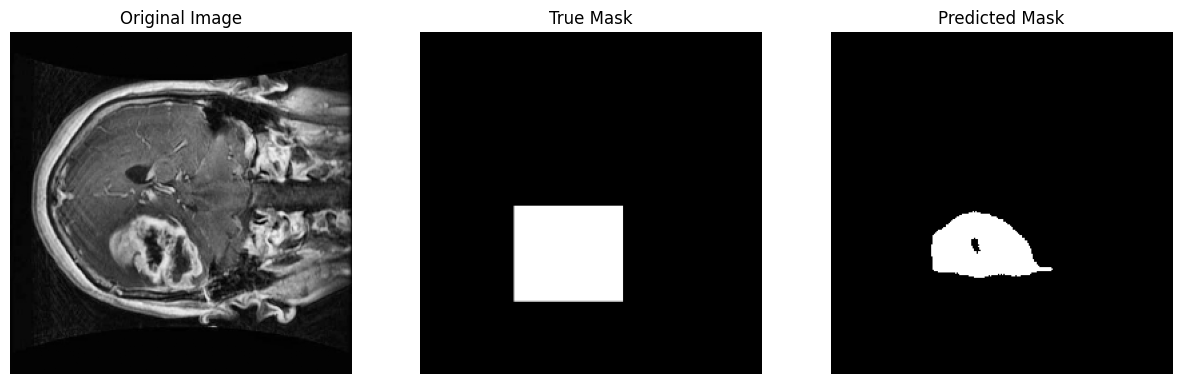

In [34]:
visualize_predictions(model, test_dataset, num_samples=10)

In [35]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import MultiHeadAttention

def downsampling_block(x, n_filters):
    c = layers.Conv2D(n_filters, (3, 3), activation='relu', padding='same')(x)
    c = layers.Conv2D(n_filters, (3, 3), activation='relu', padding='same')(c)
    p = layers.MaxPooling2D((2, 2))(c)
    return c, p

def upsampling_block(x, skip_connection, n_filters):
    u = layers.Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(x)
    u = layers.concatenate([u, skip_connection])
    c = layers.Conv2D(n_filters, (3, 3), activation='relu', padding='same')(u)
    c = layers.Conv2D(n_filters, (3, 3), activation='relu', padding='same')(c)
    return c

def multihead_attention_block(query, key, value, num_heads, key_dim):
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(query, key, value)
    return attention

def unet_model_with_multihead_attention(input_size=(256, 256, 3), n_filters=32, n_classes=1, num_heads=4, key_dim=64):
    inputs = layers.Input(input_size)

    dblock1, p1 = downsampling_block(inputs, n_filters)
    dblock2, p2 = downsampling_block(p1, n_filters * 2)
    dblock3, p3 = downsampling_block(p2, n_filters * 4)
    dblock4, p4 = downsampling_block(p3, n_filters * 8)

   
    bottleneck = layers.Conv2D(n_filters * 16, (3, 3), activation='relu', padding='same')(p4)
    bottleneck = layers.Conv2D(n_filters * 16, (3, 3), activation='relu', padding='same')(bottleneck)
    
    attention = multihead_attention_block(bottleneck, bottleneck, bottleneck, num_heads, key_dim)
    attention = layers.LayerNormalization()(attention) 
    
    u6 = upsampling_block(attention, dblock4, n_filters * 8)
    u7 = upsampling_block(u6, dblock3, n_filters * 4)
    u8 = upsampling_block(u7, dblock2, n_filters * 2)
    u9 = upsampling_block(u8, dblock1, n_filters)

    outputs = layers.Conv2D(n_classes, (1, 1), activation='sigmoid' if n_classes == 1 else 'softmax')(u9)

    model = models.Model(inputs, outputs)

    return model

model_with_mha = unet_model_with_multihead_attention(input_size=(256, 256, 3), n_filters=32)


### 1. **Downsampling Block:**
The `downsampling_block` function remains the same, where two convolution layers are followed by max-pooling. These blocks reduce the spatial dimensions of the input.

```python
def downsampling_block(x, n_filters):
    c = layers.Conv2D(n_filters, (3, 3), activation='relu', padding='same')(x)
    c = layers.Conv2D(n_filters, (3, 3), activation='relu', padding='same')(c)
    p = layers.MaxPooling2D((2, 2))(c)
    return c, p
```

### 2. **Upsampling Block:**
Similarly, the `upsampling_block` function includes a transposed convolution (also known as deconvolution) followed by concatenation with the skip connection and additional convolution layers to restore spatial resolution.

```python
def upsampling_block(x, skip_connection, n_filters):
    u = layers.Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(x)
    u = layers.concatenate([u, skip_connection])
    c = layers.Conv2D(n_filters, (3, 3), activation='relu', padding='same')(u)
    c = layers.Conv2D(n_filters, (3, 3), activation='relu', padding='same')(c)
    return c
```

### 3. **Multi-Head Attention Block:**
In the `multihead_attention_block`, the MultiHead Attention layer from Keras is used. It computes the attention mechanism using the query, key, and value (which are all the same in this case for self-attention). 

```python
def multihead_attention_block(query, key, value, num_heads, key_dim):
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(query, key, value)
    return attention
```

### 4. **U-Net Model with MultiHead Attention:**
The model uses four downsampling blocks followed by a bottleneck layer. In the bottleneck layer, after the regular convolution layers, MultiHead Attention is applied to capture long-range dependencies between features. The attention output is normalized and passed to the upsampling path to reconstruct the segmentation output.

```python
def unet_model_with_multihead_attention(input_size=(256, 256, 3), n_filters=32, n_classes=1, num_heads=4, key_dim=64):
    inputs = layers.Input(input_size)

    # Downsampling path
    dblock1, p1 = downsampling_block(inputs, n_filters)
    dblock2, p2 = downsampling_block(p1, n_filters * 2)
    dblock3, p3 = downsampling_block(p2, n_filters * 4)
    dblock4, p4 = downsampling_block(p3, n_filters * 8)

    # Bottleneck with attention
    bottleneck = layers.Conv2D(n_filters * 16, (3, 3), activation='relu', padding='same')(p4)
    bottleneck = layers.Conv2D(n_filters * 16, (3, 3), activation='relu', padding='same')(bottleneck)
    
    # MultiHead Attention
    attention = multihead_attention_block(bottleneck, bottleneck, bottleneck, num_heads, key_dim)
    attention = layers.LayerNormalization()(attention) 
    
    # Upsampling path
    u6 = upsampling_block(attention, dblock4, n_filters * 8)
    u7 = upsampling_block(u6, dblock3, n_filters * 4)
    u8 = upsampling_block(u7, dblock2, n_filters * 2)
    u9 = upsampling_block(u8, dblock1, n_filters)

    # Output layer
    outputs = layers.Conv2D(n_classes, (1, 1), activation='sigmoid' if n_classes == 1 else 'softmax')(u9)

    model = models.Model(inputs, outputs)
    return model
```

### 5. **Model Summary:**
When you call `model_with_mha.summary()`, you will see the architecture with added attention layers in the bottleneck part, which will help the model learn global features.

### 6. **Why Add MultiHead Attention?**
- **Self-Attention** helps capture long-range dependencies within an image, allowing the network to focus on relevant areas regardless of their spatial distance.
- This is especially useful for segmentation tasks, where relationships between distant regions of an image may be important.

### Model Summary:
This implementation integrates the MultiHead Attention mechanism within the U-Net architecture, helping the model focus on important features across the entire image. It is well-suited for image segmentation tasks where global context is crucial.

In [38]:
from tensorflow.keras import backend as K
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def combined_loss(y_true, y_pred):
    dice = dice_loss(y_true, y_pred)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return 0.6 * dice + 0.4 * bce

metrics = ["accuracy", dice_coef]

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model_with_mha.compile(optimizer=optimizer, loss=combined_loss, metrics=metrics)
model_with_mha.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 256, 256, 32)   │            896 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 256, 256, 32)   │          9,248 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 32)   │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 64, 64, 64)     │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 32, 32, 128)    │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 16, 16, 256)    │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 16, 16, 512)    │        525,568 │ conv2d_28[0][0],       │
│ (MultiHeadAttention)      │                        │                │ conv2d_28[0][0],       │
│                           │                        │                │ conv2d_28[0][0]        │
├──────────────────────

 Total params: 8,286,689 (31.61 MB)

 Trainable params: 8,286,689 (31.61 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
history = model_with_mha.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 43s 344ms/step - accuracy: 0.7675 - dice_coef: 0.0582 - loss: 0.7623 - val_accuracy: 0.9627 - val_dice_coef: 0.1364 - val_loss: 0.5743 - learning_rate: 1.0000e-04
Epoch 2/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 31s 336ms/step - accuracy: 0.9615 - dice_coef: 0.1555 - loss: 0.5705 - val_accuracy: 0.9622 - val_dice_coef: 0.2027 - val_loss: 0.5349 - learning_rate: 1.0000e-04
Epoch 3/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 33s 352ms/step - accuracy: 0.9556 - dice_coef: 0.2121 - loss: 0.5313 - val_accuracy: 0.9313 - val_dice_coef: 0.2667 - val_loss: 0.5026 - learning_rate: 1.0000e-04
Epoch 4/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 35s 373ms/step - accuracy: 0.9254 - dice_coef: 0.2683 - loss: 0.5044 - val_accuracy: 0.9399 - val_dice_coef: 0.3115 - val_loss: 0.4832 - learning_rate: 1.0000e-04
Epoch 5/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 383ms/step - accuracy: 0.9337 - dice_coef: 0.2942 - loss: 0.4909 - val_accuracy: 0.9457 - val_dice_coef: 0.3280 - val_loss: 0.4583 - learning_rate: 1.0000e-04


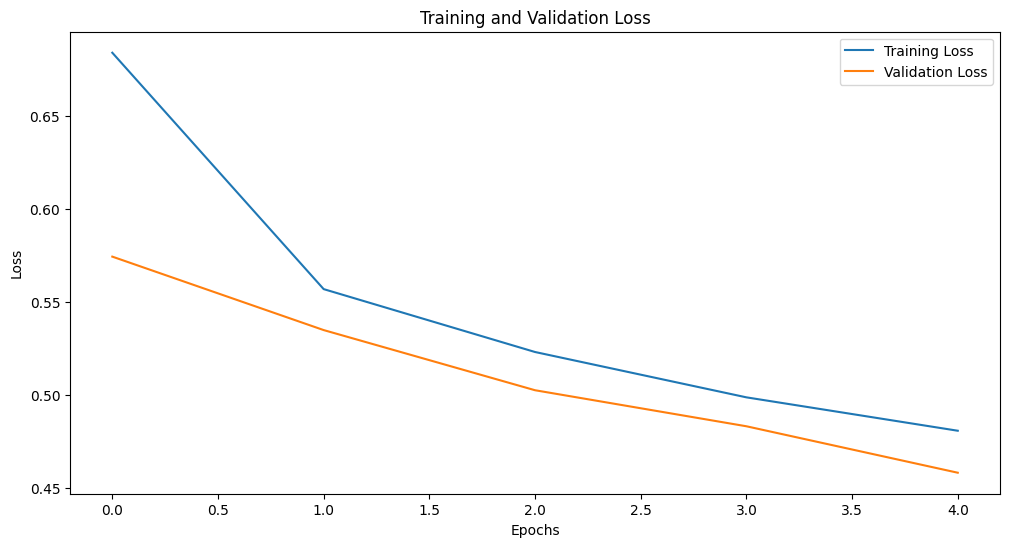

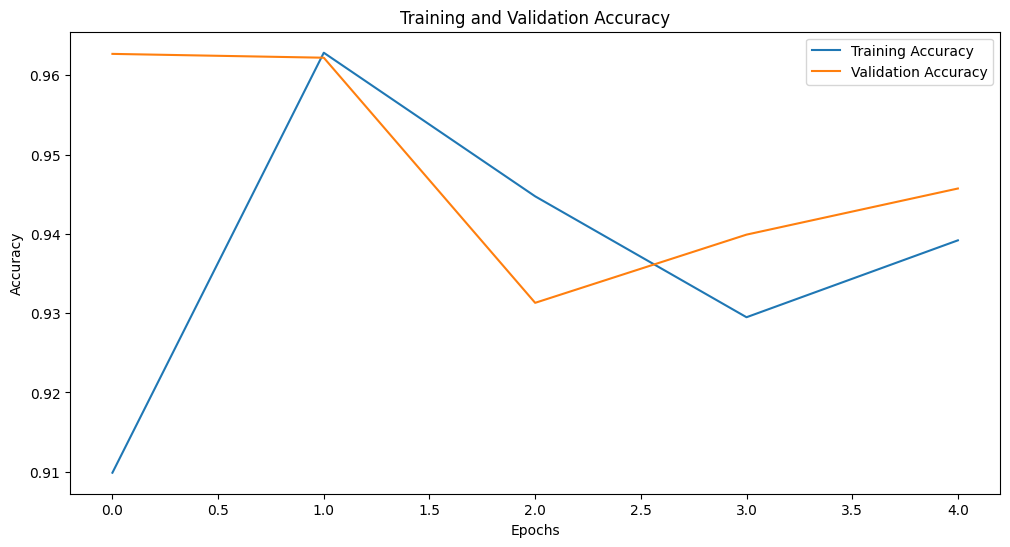

In [40]:
plot_loss(history)
plot_accuracy(history)

In [41]:
test_loss, test_accuracy, test_coef = model_with_mha.evaluate(test_dataset, steps=test_steps)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test Dice Coefficient: {test_coef}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.9593 - dice_coef: 0.1357 - loss: 0.5804
Test Loss: 0.5759785175323486, Test Accuracy: 0.9627900719642639, Test Dice Coefficient: 0.13385151326656342
